## Simple Lotka-Volterra predator-prey model

This experiment we fit a simple Lotka-Volterra dynamics

In [2]:
import numpy as np

import pyro.contrib.gp as gp
from SBIRR.SDE_solver import solve_sde_RK
from SBIRR.utils import plot_trajectories_2
import matplotlib.pyplot as plt
from SBIRR.Schrodinger import gpIPFP, SchrodingerTrain, gpdrift, nndrift
from SBIRR.GP import spatMultitaskGPModel
from SBIRR.gradient_field_NN import train_nn_gradient, GradFieldMLP

import torch
import torch.nn as nn
import memory_profiler

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

from celluloid import Camera
import math

# some plotting thingy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

/home/renb/miniconda3/envs/sb-sde/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set up the true data generating process 

In [3]:
deriv_x = lambda x,y: 1. * x - 0.4 * x * y 
deriv_y = lambda x,y: 0.1 * x * y -0.4 * y
true_drift = lambda X: torch.tensor([[deriv_x(i[0],i[1]),deriv_y(i[0],i[1])] for i in X])

Now simulate some data

In [4]:
num_samples = 50
sigma = 0.1
dt = 0.02 #0.005
N = int(math.ceil(1.0/dt))

torch.manual_seed(0)
N_steps = 5
dts = 2 * np.array([i for i in range(N_steps)])  # should make irregular eventually 
Ns = np.ceil((dts[1:]-dts[:-1])/dt).astype(int)

X_0 = torch.rand(num_samples, 2).to(device)
X_0[:,0] = X_0[:,0] * .1 + 5  # prey 
X_0[:,1] = X_0[:,1] * .1 + 4 # predator
Xs = [None for _ in range(N_steps)]
Xs[0] = X_0


for i in range(N_steps-1):
    X_0 = torch.rand(num_samples, 2).to(device)
    X_0[:,0] = X_0[:,0] * .1 + 5  # prey 
    X_0[:,1] = X_0[:,1] * .1 + 4 # predator
    _, X_tmp = solve_sde_RK(b_drift=true_drift, 
                                sigma=sigma, X0=X_0.to(device), 
                                t0 = 0, #np.sum(dts[:(i+1)]), 
                                dt=dt, 
                          N=np.sum(Ns[:(i+1)]), device = device)
    Xs[i+1] = X_tmp[:, -1, :-1]

Define our model family as an nn

In [5]:
## get a LV model
class LotkaVolterra(nn.Module):
    def __init__(self, alpha=0., beta=0., gamma=0., delta=0.):
        super(LotkaVolterra, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))
        self.gamma = nn.Parameter(torch.tensor(gamma))
        self.delta = nn.Parameter(torch.tensor(delta))
        self.relu = torch.abs

    def forward(self, x):
        alpha = self.relu(self.alpha) # things needs to be positive
        beta = self.relu(self.beta)
        gamma = self.relu(self.gamma)
        delta = self.relu(self.delta)
        dxdt =  alpha * x[:,0] - beta * x[:,0] * x[:,1]
        dydt = delta * x[:,0] * x[:,1] - gamma * x[:,1]
        return torch.stack([dxdt, dydt], dim = 1)
    def predict(self, x):
        return self.forward(x)

In [5]:
## workers to fit drift
# data
mySchrodinger_train = SchrodingerTrain(Xs, dts, sigma)

# IPFP worker
def myIPFPmaker(ref_drift = None, N = N, device = device):
    return gpIPFP(ref_drift = ref_drift, N = N, device = device)

# IPFP worker
lv = LotkaVolterra(1e-5, 1e-5, 1e-5, 1e-5) # .1,.02,.1,.02
lv.to(device)
def train_nn_gradient_verbos(model, x_train, y_train_gradient):
    train_nn_gradient(model, x_train, y_train_gradient, optimizer = None,
                      epochs = 20, lr = 0.01,verbose=True)


mynndrift = nndrift(lv.double(), train_nn_gradient, N = N)


# fit drift
IPFP_drift_fit, backnforth = mySchrodinger_train.iter_drift_fit(myIPFPmaker,
                                                                mynndrift,
                                                                ipfpiter = 10, 
                                                                iteration = 10)

  0%|          | 0/10 [00:00<?, ?it/s]  0%|          | 0/10 [01:06<?, ?it/s]


KeyboardInterrupt: 

In [6]:
[lv.alpha, lv.beta, lv.gamma, lv.delta]

[Parameter containing:
 tensor(1.1562, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(0.4555, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(0.3124, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(0.0794, dtype=torch.float64, requires_grad=True)]

In [6]:
Xs_val = [None for _ in range(2 * N_steps - 1)] # also with things in the middle
Xs_val[0] = X_0
for i in range(N_steps-1):
    # middle point 

    X_0 = torch.rand(num_samples, 2)
    X_0[:,0] = X_0[:,0] * .1 + 5  # prey 
    X_0[:,1] = X_0[:,1] * .1 + 4 # predator
    _, X_tmp = solve_sde_RK(b_drift=true_drift, 
                                sigma=sigma, X0=X_0, 
                                t0 = 0, #np.sum(dts[:(i+1)]), 
                                dt=dt, 
                          N=np.sum(Ns[:i]) + np.ceil(Ns[i]/2).astype(int), device = device)
    Xs_val[2 * i + 1] = X_tmp[:, -1, :-1]


    # endpoint in data 
    Xs_val[2 * i + 2] = Xs[i+1]

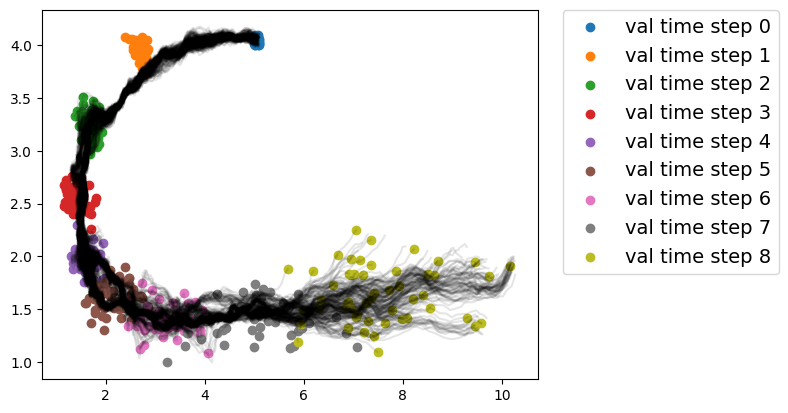

In [8]:
for i in range(len(Xs_val)):
    #if (i % 2) != 0:
    plt.scatter(Xs_val[i][:,0], Xs_val[i][:,1], label=f'val time step {i}', alpha=1)

for i in range(backnforth.shape[0]):
    plt.plot(backnforth[i,:,0], backnforth[i,:,1], color = "black", alpha = 0.1)
    #plt.plot(vanilla_interpolation[i,:,0], vanilla_interpolation[i,:,1], color = "red", alpha = 0.1)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)


Vanilla

In [9]:
## workers to fit drift
# data
mySchrodinger_train_vSB = SchrodingerTrain(Xs, dts, sigma)

# IPFP worker
def myIPFPmaker(ref_drift = None, N = N, device = device):
    return gpIPFP(ref_drift = ref_drift, N = N, device = device)

# IPFP worker
lv_vSB = LotkaVolterra() # .1,.02,.1,.02
lv_vSB.to(device)
mynndrift_vSB = nndrift(lv_vSB.double(), train_nn_gradient, N = N)


# fit drift
IPFP_drift_fit_vSB, backnforth_vSB = mySchrodinger_train_vSB.iter_drift_fit(myIPFPmaker,
                                                                mynndrift_vSB,
                                                                ipfpiter = 10, 
                                                                iteration = 1)

100%|██████████| 1/1 [01:54<00:00, 114.93s/it]


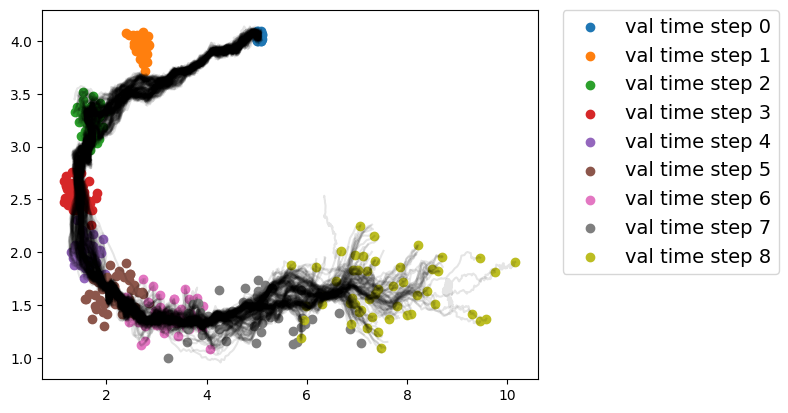

In [10]:
for i in range(len(Xs_val)):
    #if (i % 2) != 0:
    plt.scatter(Xs_val[i][:,0], Xs_val[i][:,1], label=f'val time step {i}', alpha=1)

for i in range(backnforth_vSB.shape[0]):
    plt.plot(backnforth_vSB[i,:,0], backnforth_vSB[i,:,1], 
             color = "black", alpha = 0.1)
    #plt.plot(vanilla_interpolation[i,:,0], vanilla_interpolation[i,:,1], color = "red", alpha = 0.1)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)


### Plot DM-SB results

In [38]:
# import trajectory from dm-sb
dmsb_traj = np.load("../notebooks/results/LV_gpu_20/replaced_traj.npy")
dmsb_traj.shape

(20, 400, 4)

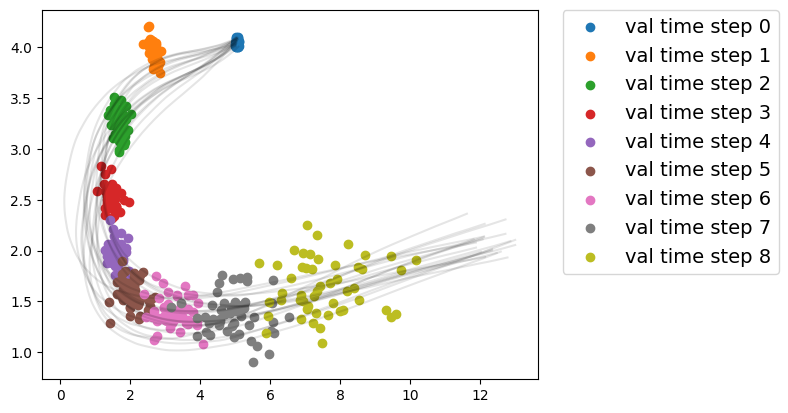

In [39]:
for i in range(len(Xs_val)):
    #if (i % 2) != 0:
    plt.scatter(Xs_val[i][:,0], Xs_val[i][:,1], label=f'val time step {i}', alpha=1)

for i in range(dmsb_traj.shape[0]):
    plt.plot(dmsb_traj[i,:,0], dmsb_traj[i,:,1], color = "black", alpha = 0.1)
    #plt.plot(vanilla_interpolation[i,:,0], vanilla_interpolation[i,:,1], color = "red", alpha = 0.1)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)

In [29]:
len(Xs_val)

9

Let's calculate some distance

In [30]:
from TrajectoryNet.optimal_transport.emd import earth_mover_distance

In [40]:
traj_loc = dmsb_traj[:,:,:2]
emd_val = []

for i in range(4):# draw five validation snapshots only
    emd_this_time = [earth_mover_distance(Xs_val[2 * i + 1], traj_loc[:,int((traj_loc.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:])]
    #emd_this_time.append(earth_mover_distance(Xs_val[2 * i + 1], backnforth_vSB.detach()[:,int((backnforth.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:-1]))
    #emd_this_time.append()
    emd_val.append(emd_this_time)

emd_val

[[0.5628900818791166],
 [0.5821318803365957],
 [0.41868142438009426],
 [1.9276112180518974]]